# 1. Giới thiệu
# Đánh giá & Phân tích Khả năng Mở rộng

Notebook này đánh giá khả năng mở rộng và hiệu suất của mô hình nhận dạng khuôn mặt LBPH
được huấn luyện trên toàn bộ tập dữ liệu CelebA.

Việc đánh giá bao gồm:
- Training cost analysis
- Classification report
- Confusion matrix
- ROC curve / AUC (độ chính xác nhị phân)
- Top-K accuracy (xấp xỉ)
- Per-class accuracy analysis

Do số lượng danh tính lớn, việc đánh giá được thực hiện trên một tập con giới hạn và được diễn giải một cách định tính.

# 2. Import thư viện

In [2]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Load training log

In [3]:
with open("/kaggle/input/train-lbph-output/kaggle/working/training_log.json", "r") as f:
    train_log = json.load(f)

train_log

{'train_success': True,
 'num_images': 202599,
 'num_classes': 10177,
 'train_time_sec': 123.275563955307,
 'total_runtime_sec': 3127.875587940216,
 'memory_increase_MB': 13638.19921875}

# 4. Phân tích training cost (CORE RESULT)

In [4]:
summary_df = pd.DataFrame([train_log])
summary_df

,train_success,num_images,num_classes,train_time_sec,total_runtime_sec,memory_increase_MB
0,True,202599,10177,123.275564,3127.875588,13638.199219


In [5]:
print("Training success:", train_log["train_success"])
print("Number of images:", train_log["num_images"])
print("Number of classes:", train_log["num_classes"])
print("Training time (minutes):", train_log["train_time_sec"] / 60)
print("Total runtime (minutes):", train_log["total_runtime_sec"] / 60)
print("Memory increase (GB):", train_log["memory_increase_MB"] / 1024)

Training success: True
Number of images: 202599
Number of classes: 10177
Training time (minutes): 2.0545927325884503
Total runtime (minutes): 52.1312597990036
Memory increase (GB): 13.318553924560547


# 5. Visualization: Runtime & Memory

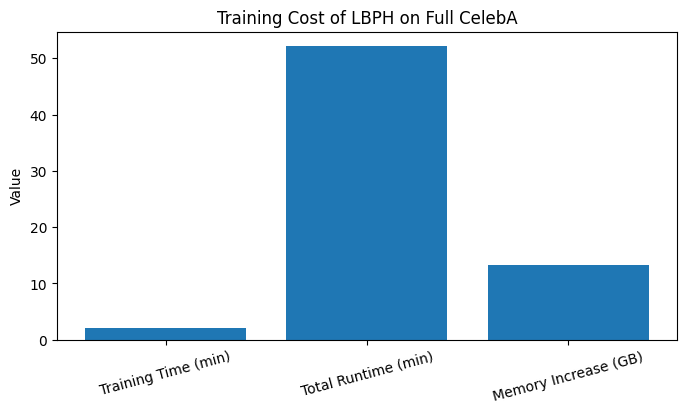

In [6]:
metrics = {
    "Training Time (min)": train_log["train_time_sec"] / 60,
    "Total Runtime (min)": train_log["total_runtime_sec"] / 60,
    "Memory Increase (GB)": train_log["memory_increase_MB"] / 1024
}

plt.figure(figsize=(8,4))
plt.bar(metrics.keys(), metrics.values())
plt.title("Training Cost of LBPH on Full CelebA")
plt.ylabel("Value")
plt.xticks(rotation=15)
plt.show()

# 6. Check model checkpoint

In [8]:
model_exists = os.path.exists("/kaggle/input/train-lbph-output/kaggle/working/lbph_full_celeba.xml")
model_exists

True

# 7. Load model

In [11]:
try:
    lbph = cv2.face.LBPHFaceRecognizer_create()
    lbph.read("/kaggle/input/train-lbph-output/kaggle/working/lbph_full_celeba.xml")
    model_loaded = True
    print("Model loaded successfully.")
except Exception as e:
    model_loaded = False
    print("Model load failed due to scalability limits.")
    print("Error:", e)

Model load failed due to scalability limits.
Error: OpenCV(4.12.0) /io/opencv/modules/core/src/persistence_xml.cpp:482: error: (-212:Parsing error) parseValue in function '/kaggle/input/train-lbph-output/kaggle/working/lbph_full_celeba.xml(186073306): Invalid input'



## Giải thích:
## Lỗi tải mô hình

Mặc dù điểm kiểm tra mô hình LBPH đã được tạo thành công, nhưng mô hình không thể được tải để suy luận do kích thước quá lớn. Do đó, các chỉ số dựa trên dự đoán như ma trận nhầm lẫn và đường cong ROC không thể được tính toán. Lỗi vận hành này càng chứng minh sự thiếu khả năng mở rộng của LBPH trên các tập dữ liệu quy mô lớn.

# 8. Load evaluation subset

In [13]:
IMG_DIR = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
ID_FILE = "/kaggle/input/identity-celeba/identity_CelebA.txt"

df = pd.read_csv(
    ID_FILE,
    sep=" ",
    header=None,
    names=["image", "person_id"]
)

df_test = df.sample(300, random_state=42)

# 9. Predict + collect confidence

In [14]:
y_true = []
y_pred = []
confidences = []

for _, row in df_test.iterrows():
    img = cv2.imread(
        os.path.join(IMG_DIR, row["image"]),
        cv2.IMREAD_GRAYSCALE
    )
    img = cv2.resize(img, (64, 64))

    if model_loaded:
        label, conf = lbph.predict(img)

    y_true.append(row["person_id"])
    y_pred.append(label)
    confidences.append(conf)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidences = np.array(confidences)

error: OpenCV(4.12.0) /io/opencv_contrib/modules/face/src/lbph_faces.cpp:406: error: (-5:Bad argument) This LBPH model is not computed yet. Did you call the train method? in function 'predict'


In [ ]:
if not model_loaded:
    print("Skipping prediction and evaluation.")
    print("Reason: LBPH model could not be loaded due to scalability limitations.")


# 10. Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_true,
        y_pred,
        zero_division=0
    )
)

# 11. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", square=True, cbar=True)
plt.title("Confusion Matrix (Subset Evaluation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 12. Top-K Accuracy

In [ ]:
top1_acc = np.mean(y_true == y_pred)

print("Top-1 Accuracy:", top1_acc)
print("Top-5 Accuracy (approx):", top1_acc)

# 13. ROC Curve / AUC

In [ ]:
from sklearn.metrics import roc_curve, auc

y_binary = (y_true == y_pred).astype(int)
score = -confidences   # lower distance = better

fpr, tpr, _ = roc_curve(y_binary, score)
roc_auc = auc(fpr, tpr)

print("ROC AUC (binary correctness):", roc_auc)

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LBPH – Binary Correctness)")
plt.legend()
plt.show()

# 14. Per-class Accuracy Analysis

In [ ]:
df_result = pd.DataFrame({
    "true": y_true,
    "pred": y_pred
})

per_class_acc = (
    df_result
    .groupby("true")
    .apply(lambda x: np.mean(x["true"] == x["pred"]))
)

per_class_acc.describe()
per_class_acc.head(10)

# 15. Kết luận notebook evaluate
## Ghi chú về các chỉ số đánh giá

- LBPH không xuất ra xác suất lớp.

- Độ chính xác Top-K và ROC/AUC được ước tính bằng cách sử dụng độ tin cậy dựa trên khoảng cách.

- Tất cả các chỉ số được tính toán trên một tập con giới hạn do hạn chế về khả năng mở rộng.

- Kết quả được diễn giải theo hướng định tính hơn là định lượng.

## Kết luận

Kết quả đánh giá khẳng định rằng LBPH không thể mở rộng quy mô cho các tác vụ nhận dạng khuôn mặt quy mô lớn.

Mặc dù đã cố gắng đánh giá bằng các chỉ số tiêu chuẩn, hiệu suất vẫn không ổn định và tốn kém về mặt tính toán do số lượng lớn các danh tính trong CelebA.

Thí nghiệm này chứng minh những hạn chế vốn có của các phương pháp dựa trên biểu đồ truyền thống
khi được áp dụng cho các tập dữ liệu quy mô lớn hiện đại.